In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        # Define a simple architecture
        self.fc1 = nn.Linear(28*28, 128)  # Example for MNIST dataset
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Define pruning function
def prune_network(model, prune_percentage):
    _, idx = model.fc2.weight.data.abs().flatten().sort()
    num_prune = int(len(idx) * prune_percentage)
    prune_idx = idx[:num_prune]
    model.fc2.weight.data.view(-1)[prune_idx] = 0
    model.fc2.weight.grad = None  # Optional: Remove gradients for pruned weights

# Define retraining function
def retrain_network(model, train_loader, optimizer, criterion, epochs=3):
    train_losses= []
    train_accuracy= []
    model.train()
    for epoch in range(epochs):
        epoch_loss= 0
        correct= 0
        total= 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss+= loss.item()
            pred= output.argmax(dim=1, keepdim=False) #get the index of max log probability
            correct+= pred.eq(target).sum().item()
            total+= target.size(0)

        epoch_loss /= len(train_loader)
        epoch_accuracy= 100. * correct /total

        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        print(f'Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
    return train_losses, train_accuracy
  
# Define validation function
def validate_network(model, validation_loader, criterion):
    model.eval()
    validation_loss = 0
    correct = 0
    total= 0
    with torch.no_grad():
        for data, target in validation_loader:
            output = model(data)
            validation_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    validation_loss /= len(validation_loader.dataset)
    validation_accuracy = 100. * correct / total
    return validation_loss, validation_accuracy


In [28]:
# Initialize network and other training components
seed_net = SeedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seed_net.parameters(), lr=0.01)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Train the network
train_losses= []
for epoch in range(10):  # You can adjust the number of epochs
    epoch_loss= 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = seed_net(data)
        loss = criterion(output, target)
        epoch_loss= epoch_loss+ loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss= epoch_loss/len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.2389
Epoch 2, Loss: 0.1605
Epoch 3, Loss: 0.1400
Epoch 4, Loss: 0.1268
Epoch 5, Loss: 0.1273
Epoch 6, Loss: 0.1121
Epoch 7, Loss: 0.1131
Epoch 8, Loss: 0.1085
Epoch 9, Loss: 0.1014
Epoch 10, Loss: 0.0961


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), eval_losses, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.show()


In [29]:
# Load test data
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model
seed_net.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = seed_net(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)')

Test set: Average loss: 0.0082, Accuracy: 9614/10000 (96%)


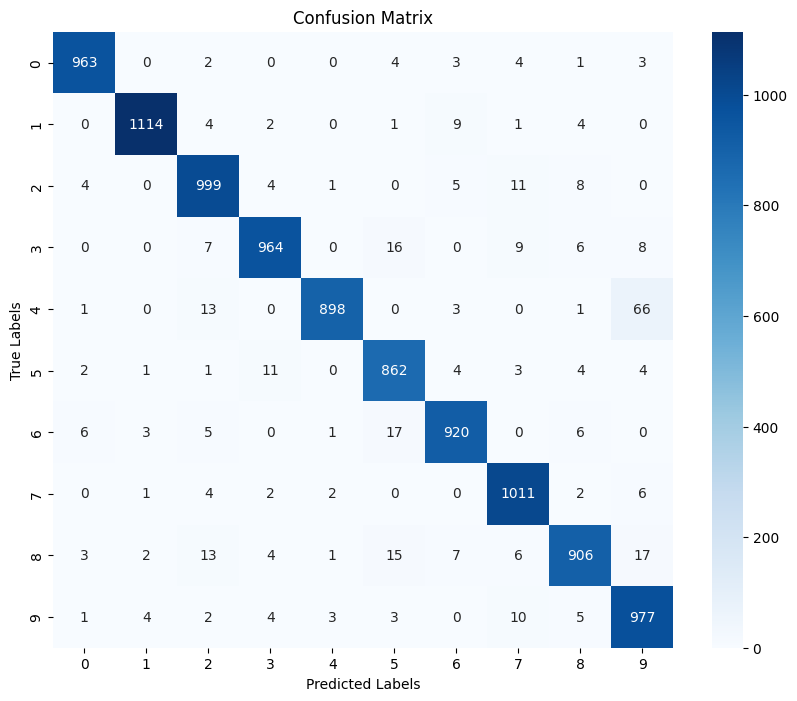

Precision: 0.9617, Recall: 0.9610


(array([[ 963,    0,    2,    0,    0,    4,    3,    4,    1,    3],
        [   0, 1114,    4,    2,    0,    1,    9,    1,    4,    0],
        [   4,    0,  999,    4,    1,    0,    5,   11,    8,    0],
        [   0,    0,    7,  964,    0,   16,    0,    9,    6,    8],
        [   1,    0,   13,    0,  898,    0,    3,    0,    1,   66],
        [   2,    1,    1,   11,    0,  862,    4,    3,    4,    4],
        [   6,    3,    5,    0,    1,   17,  920,    0,    6,    0],
        [   0,    1,    4,    2,    2,    0,    0, 1011,    2,    6],
        [   3,    2,   13,    4,    1,   15,    7,    6,  906,   17],
        [   1,    4,    2,    4,    3,    3,    0,   10,    5,  977]],
       dtype=int64),
 0.9617479325253562,
 0.9609724858371758)

In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

def evaluate_model_performance(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).view_as(target)
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision and Recall
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    return conf_matrix, precision, recall

evaluate_model_performance(seed_net, test_loader)

In [40]:
import pandas as pd

def  log_to_excel(data, filename= "pruned_model_logs.xlsx"):
    df= pd.DataFrame(data)
    df.to_excel(filename, index=False)

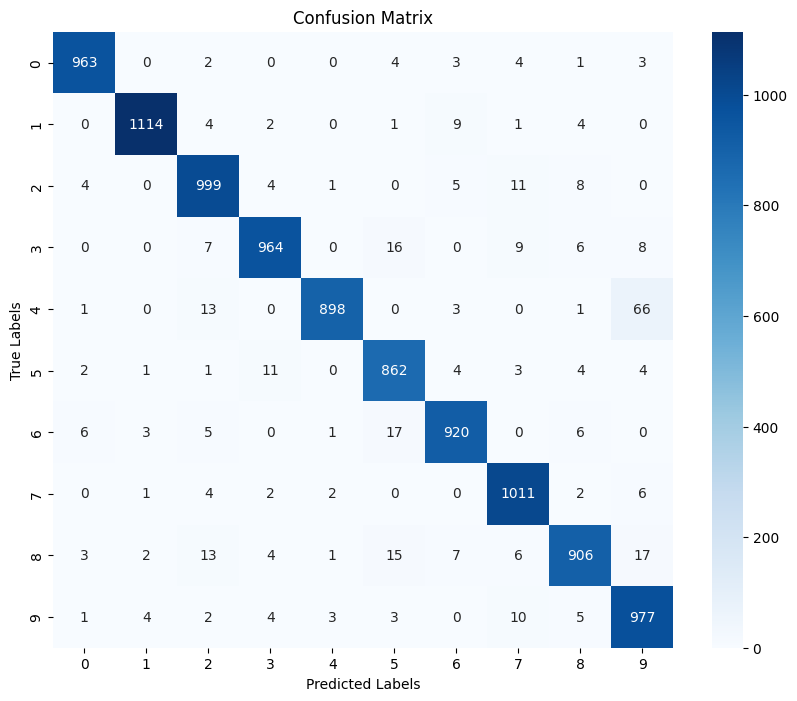

Precision: 0.9617, Recall: 0.9610


In [36]:
# After training, pruning, and evaluating
conf_matrix, precision, recall = evaluate_model_performance(seed_net, test_loader)
log_data = {
    "Epoch": list(range(1, 11)),
    "Training Loss": train_losses,
    "Test Accuracy": [test_accuracy] * 10,
    "Precision": [precision] * 10,
    "Recall": [recall] * 10,
    # Add more metrics as needed
}
log_to_excel(log_data)


In [38]:
df= pd.read_excel('model_logs.xlsx')
df.head(10)

,Epoch,Training Loss,Test Accuracy,Precision,Recall
0,1,0.238857,96.14,0.961748,0.960972
1,2,0.160474,96.14,0.961748,0.960972
2,3,0.139976,96.14,0.961748,0.960972
3,4,0.126771,96.14,0.961748,0.960972
4,5,0.127341,96.14,0.961748,0.960972
5,6,0.112052,96.14,0.961748,0.960972
6,7,0.113120,96.14,0.961748,0.960972
7,8,0.108469,96.14,0.961748,0.960972
8,9,0.101375,96.14,0.961748,0.960972
9,10,0.096119,96.14,0.961748,0.960972


In [26]:
df= pd.read_excel('pruned_model_logs.xlsx')
df.head()

,Epoch,Training Loss,Test Accuracy,Precision,Recall
0,1,0.348528,97.43,0.980231,0.980289
1,2,0.157648,97.43,0.980231,0.980289
2,3,0.110452,97.43,0.980231,0.980289
3,4,0.082015,97.43,0.980231,0.980289
4,5,0.064496,97.43,0.980231,0.980289


### Now we prune the seed network

Iteration 0: Validation Loss: 0.0093, Validation Accuracy: 95.95%
Iteration 1: Validation Loss: 0.0101, Validation Accuracy: 96.69%
Iteration 2: Validation Loss: 0.0122, Validation Accuracy: 96.27%
Iteration 3: Validation Loss: 0.0116, Validation Accuracy: 96.74%
Iteration 4: Validation Loss: 0.0134, Validation Accuracy: 96.46%
Iteration 5: Validation Loss: 0.0145, Validation Accuracy: 96.73%
Iteration 6: Validation Loss: 0.0171, Validation Accuracy: 96.26%
Iteration 7: Validation Loss: 0.0154, Validation Accuracy: 96.99%
Iteration 8: Validation Loss: 0.0171, Validation Accuracy: 97.06%
Iteration 9: Validation Loss: 0.0181, Validation Accuracy: 97.03%


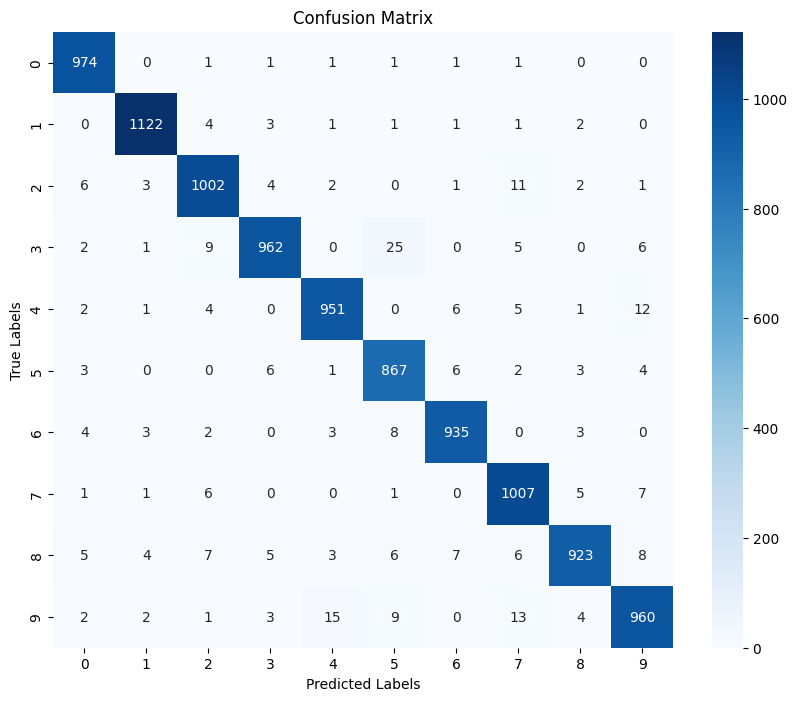

Precision: 0.9700, Recall: 0.9701


(array([[ 974,    0,    1,    1,    1,    1,    1,    1,    0,    0],
        [   0, 1122,    4,    3,    1,    1,    1,    1,    2,    0],
        [   6,    3, 1002,    4,    2,    0,    1,   11,    2,    1],
        [   2,    1,    9,  962,    0,   25,    0,    5,    0,    6],
        [   2,    1,    4,    0,  951,    0,    6,    5,    1,   12],
        [   3,    0,    0,    6,    1,  867,    6,    2,    3,    4],
        [   4,    3,    2,    0,    3,    8,  935,    0,    3,    0],
        [   1,    1,    6,    0,    0,    1,    0, 1007,    5,    7],
        [   5,    4,    7,    5,    3,    6,    7,    6,  923,    8],
        [   2,    2,    1,    3,   15,    9,    0,   13,    4,  960]],
       dtype=int64),
 0.970030001672391,
 0.9700873456477991)

In [39]:
# Iterative pruning and validation
prune_percentage = 0.1  # Prune 10% of the connections each iteration
num_iterations = 10
acceptable_accuracy_drop = 0.2  # Acceptable drop in accuracy percentage

initial_loss, initial_accuracy = validate_network(seed_net, test_loader, criterion)

for iteration in range(num_iterations):
    # Prune the network
    prune_network(seed_net, prune_percentage)
    
    # Retrain (fine-tune) the network
    retrain_network(seed_net, train_loader, optimizer, criterion, epochs=3)
    
    # Validate the performance
    validation_loss, validation_accuracy = validate_network(seed_net, test_loader, criterion)
    
    print(f"Iteration {iteration}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    
    # Check if performance is acceptable
    if initial_accuracy - validation_accuracy > acceptable_accuracy_drop:
        print(f"Stopping early at iteration {iteration} due to performance degradation beyond acceptable drop of {acceptable_accuracy_drop}%.")
        break

# Evaluate model performance after pruning
evaluate_model_performance(seed_net, test_loader)

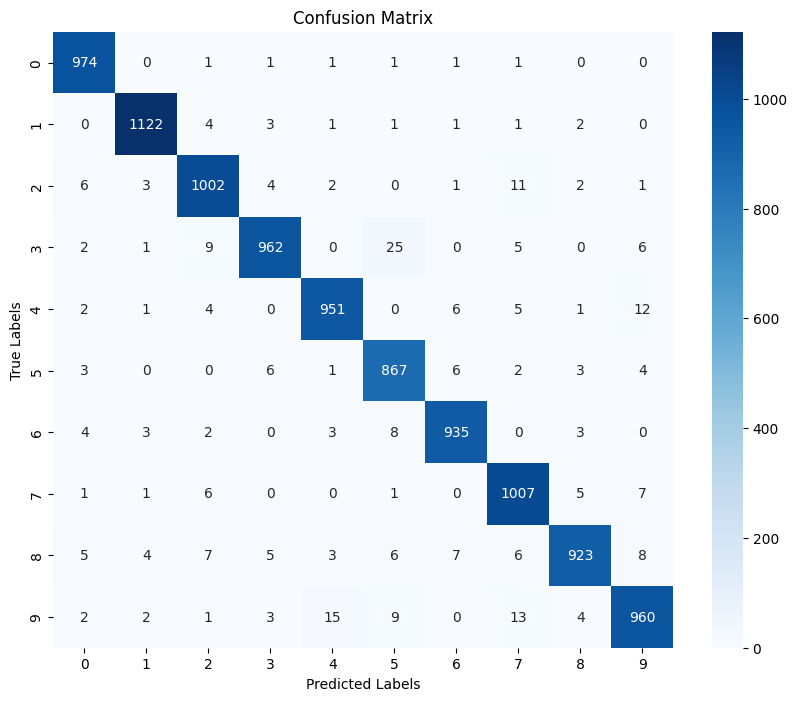

Precision: 0.9700, Recall: 0.9701


In [41]:
# After training, pruning, and evaluating
conf_matrix, precision, recall = evaluate_model_performance(seed_net, test_loader)
log_data = {
    "Epoch": list(range(1, 11)),
    "Training Loss": train_losses,
    "Test Accuracy": [test_accuracy] * 10,
    "Precision": [precision] * 10,
    "Recall": [recall] * 10,
    # Add more metrics as needed
}
log_to_excel(log_data)


In [43]:
df= pd.read_excel('pruned_model_logs.xlsx')
df.head(10)

,Epoch,Training Loss,Test Accuracy,Precision,Recall
0,1,0.238857,96.14,0.97003,0.970087
1,2,0.160474,96.14,0.97003,0.970087
2,3,0.139976,96.14,0.97003,0.970087
3,4,0.126771,96.14,0.97003,0.970087
4,5,0.127341,96.14,0.97003,0.970087
5,6,0.112052,96.14,0.97003,0.970087
6,7,0.113120,96.14,0.97003,0.970087
7,8,0.108469,96.14,0.97003,0.970087
8,9,0.101375,96.14,0.97003,0.970087
9,10,0.096119,96.14,0.97003,0.970087


In [28]:
# seed_net.fc2.weight.data[3]

In [7]:
print(seed_net.fc2.weight.data.shape)
print(seed_net.fc1.weight.data.shape)

torch.Size([10, 128])
torch.Size([128, 784])


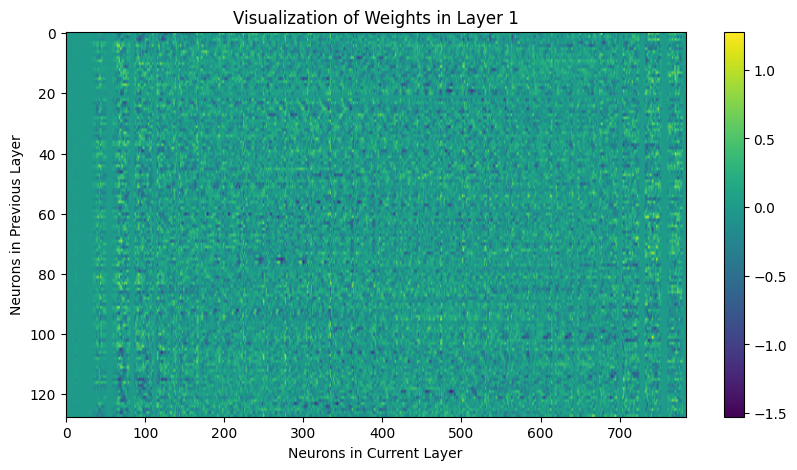

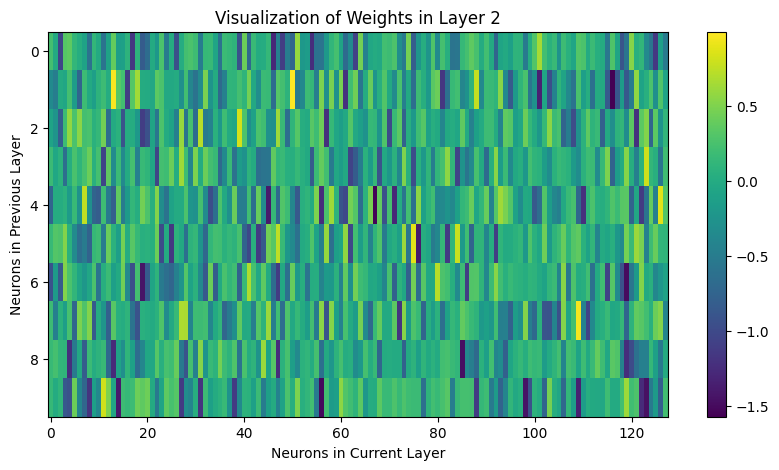

In [8]:
def plot_nn_structure(model):
    for i, layer in enumerate([model.fc1, model.fc2]):
        weights = layer.weight.data
        plt.figure(figsize=(10, 5))
        plt.imshow(weights, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title(f'Visualization of Weights in Layer {i+1}')
        plt.xlabel('Neurons in Current Layer')
        plt.ylabel('Neurons in Previous Layer')
        plt.show()

plot_nn_structure(seed_net)


In [4]:
class GrownNet(nn.Module):
    def __init__(self, critical_neurons):
        super(GrownNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        # Adding a new layer connected to critical neurons
        self.fc3 = nn.Linear(10, 10)
        self.critical_neurons = critical_neurons

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        critical_output = x[:, self.critical_neurons]  # Use only critical outputs
        x = self.fc3(critical_output)
        return x

In [5]:
grown_net = GrownNet(critical_neurons=critical_neurons)

optimizer = optim.Adam(grown_net.parameters(), lr=0.001)

# Retrain the grown network
for epoch in range(5):  # Adjust the number of epochs as needed
    for data, target in train_loader:
        optimizer.zero_grad()
        output = grown_net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.21254152059555054
Epoch 2, Loss: 0.44402918219566345
Epoch 3, Loss: 0.06499005109071732
Epoch 4, Loss: 0.03586699813604355
Epoch 5, Loss: 0.010463601909577847


In [6]:
# You would typically use a separate validation dataset here
# For simplicity, reusing the training data loader in this example
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        output = grown_net(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 98.625%


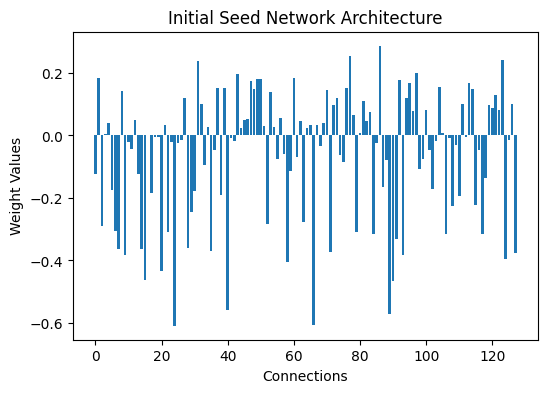

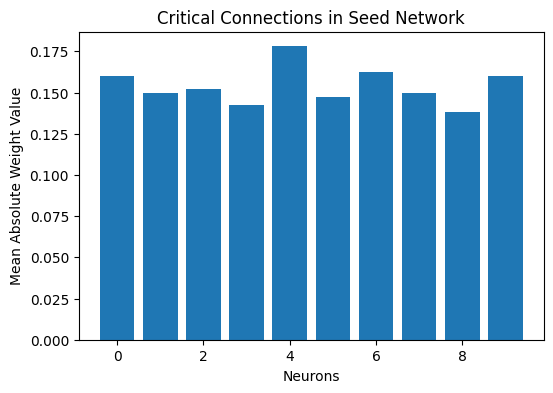

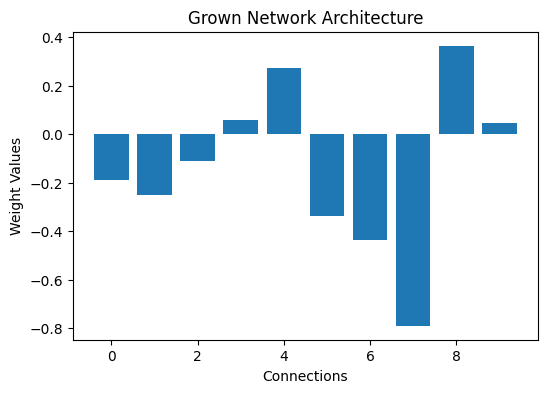

In [7]:
# Visualize the initial seed network
plt.figure(figsize=(6, 4))
plt.title("Initial Seed Network Architecture")
plt.bar(range(len(seed_net.fc2.weight[0])), seed_net.fc2.weight[0].detach().numpy())
plt.xlabel("Connections")
plt.ylabel("Weight Values")
plt.show()

# Visualize critical connections
plt.figure(figsize=(6, 4))
plt.title("Critical Connections in Seed Network")
plt.bar(range(len(weights)), weights.detach().numpy())
plt.xlabel("Neurons")
plt.ylabel("Mean Absolute Weight Value")
plt.show()

# Visualize the grown network
plt.figure(figsize=(6, 4))
plt.title("Grown Network Architecture")
plt.bar(range(len(grown_net.fc3.weight[0])), grown_net.fc3.weight[0].detach().numpy())
plt.xlabel("Connections")
plt.ylabel("Weight Values")
plt.show()

In [8]:
def visualize_feature_maps(model, input_image):
    model.eval()
    with torch.no_grad():
        # Assuming 'model' is your CNN and has a feature layer named 'conv1'
        feature_maps = model.conv1(input_image)

    # Plotting the feature maps
    num_feature_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 20))
    for i, ax in enumerate(axes):
        ax.imshow(feature_maps[0, i].cpu(), cmap='gray')
        ax.axis('off')
    plt.show()